In [0]:
from google.colab import drive
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import glob
from sklearn.preprocessing import normalize
import gc
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D 
from keras.models import Model
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import accuracy_score
from keras.layers import Dropout

In [2]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
def trainingSet(file_name):
  training_set = []
  for np_name in sorted(glob.glob('MRNet-v1.0/train/'+file_name+'/*.npy')):
        training_set.append(np.load(np_name))
  return training_set    

In [0]:
def load_labels(train_file_name):
  training_labels = np.loadtxt(train_file_name, delimiter=',')[:,1]
  return training_labels

In [0]:
def extract_3(dataset, data_size):
  for i in range(len(dataset)):
    dataset[i] = list(dataset[i])
    middel_idx = int(len(dataset[i]) / 2)
    dataset[i] = dataset[i][middel_idx - 1 : middel_idx + 2]
    dataset[i] = np.array(dataset[i])
  dataset = np.array(dataset)
  dataset = dataset.reshape(data_size, 256, 256 ,3)
  return dataset

In [0]:
training_set_axial= trainingSet('axial')
training_set_coronal=trainingSet('coronal')
training_set_sagittal=trainingSet('sagittal')

In [0]:
training_set_axial = extract_3(training_set_axial, 1130)
training_set_coronal =extract_3(training_set_coronal, 1130)
training_set_sagittal =extract_3(training_set_sagittal, 1130)

In [0]:
training_label_abnormal = load_labels('MRNet-v1.0/train-abnormal.csv')
training_label_acl = load_labels('MRNet-v1.0/train-acl.csv')
training_label_meniscus = load_labels('MRNet-v1.0/train-meniscus.csv')

In [10]:
mri_InceptionV3 = InceptionV3(include_top = False, input_shape = (256, 256, 3))
#remove the last one
#mri_InceptionV3.layers.pop()
mri_InceptionV3_output = mri_InceptionV3.output

mri_InceptionV3_last_layer = GlobalMaxPooling2D()(mri_InceptionV3_output)

mri_InceptionV3_last_layer = Dense(1024, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(128, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(32, activation = 'relu')(mri_InceptionV3_last_layer)

predictor = Dense(1, activation='sigmoid')(mri_InceptionV3_last_layer)

modified_mri_InceptionV3 = Model(inputs = mri_InceptionV3.input, output = predictor)
modified_mri_InceptionV3 = Dropout(0.5, noise_shape=None, seed=None)

modified_mri_InceptionV3.summary()

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [0]:
#freeze the first 10 layers and unfreeze the rest:
for layer in mri_InceptionV3.layers:
   layer.trainable = False
    
#for layer in modified_mri_InceptionV3.layers[15:]:
   #layer.trainable = True    
    
modified_mri_InceptionV3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [0]:
def fit_model(training_set, training_labels, model_file_name):
  history = modified_mri_InceptionV3.fit(x = training_set, y = training_labels, batch_size=32,
                       epochs=30, validation_split = 0.05,
                       callbacks =[
                          EarlyStopping(patience=3, monitor = 'val_loss', mode = 'min'),
                          ModelCheckpoint(model_file_name, monitor='val_loss', save_best_only=True, mode='min', period=1)])
  
  plt.figure()
  plt.title('Training performance')
  plt.plot(history.epoch, history.history['loss'], label='train loss')
  plt.plot(history.epoch, history.history['val_loss'], label='val loss')
  plt.legend()
  best_model = load_model(model_file_name)
  return best_model

Instructions for updating:
Use tf.cast instead.
Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 12s 12ms/step - loss: 0.9449 - acc: 0.7269 - val_loss: 1.7528 - val_acc: 0.8421
Epoch 2/30
1073/1073 [==============================] - 5s 4ms/step - loss: 0.4993 - acc: 0.7996 - val_loss: 13.3218 - val_acc: 0.1579
Epoch 3/30
1073/1073 [==============================] - 5s 4ms/step - loss: 0.5224 - acc: 0.7838 - val_loss: 2.5051 - val_acc: 0.8421
Epoch 4/30
1073/1073 [==============================] - 5s 4ms/step - loss: 0.5202 - acc: 0.7968 - val_loss: 1.1399 - val_acc: 0.7895
Epoch 5/30
1073/1073 [==============================] - 5s 5ms/step - loss: 0.4183 - acc: 0.8183 - val_loss: 2.3615 - val_acc: 0.8421
Epoch 6/30
1073/1073 [==============================] - 5s 4ms/step - loss: 0.4224 - acc: 0.8164 - val_loss: 2.9887 - val_acc: 0.4561
Epoch 7/30
1073/1073 [==============================] - 5s 4ms/step - loss: 0.4217 - acc: 0.8155 - 

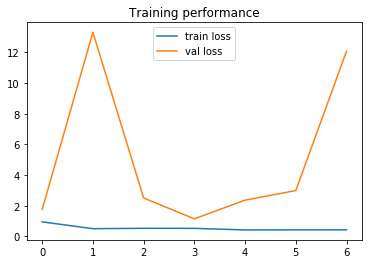

In [13]:
axial_abnormal_model = fit_model(training_set_axial, training_label_abnormal, "axial_abnormal_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.7645 - acc: 0.7484 - val_loss: 2.5450 - val_acc: 0.8421
Epoch 2/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4654 - acc: 0.8155 - val_loss: 1.8821 - val_acc: 0.8421
Epoch 3/30
1073/1073 [==============================] - 4s 3ms/step - loss: 0.4535 - acc: 0.8164 - val_loss: 2.5060 - val_acc: 0.8421
Epoch 4/30
1073/1073 [==============================] - 4s 3ms/step - loss: 0.4056 - acc: 0.8155 - val_loss: 2.5450 - val_acc: 0.8421
Epoch 5/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4028 - acc: 0.8378 - val_loss: 2.4799 - val_acc: 0.8421


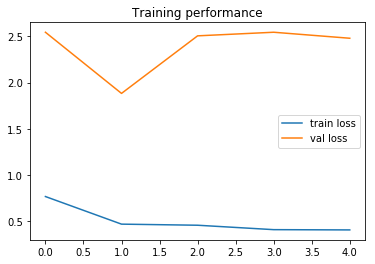

In [14]:
axial_acl_model = fit_model(training_set_axial, training_label_acl, "axial_acl_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.6126 - acc: 0.6598 - val_loss: 5.6709 - val_acc: 0.6140
Epoch 2/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.5939 - acc: 0.6580 - val_loss: 6.0826 - val_acc: 0.6140
Epoch 3/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.5633 - acc: 0.6980 - val_loss: 5.9461 - val_acc: 0.6140
Epoch 4/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.5559 - acc: 0.6915 - val_loss: 5.9134 - val_acc: 0.6140


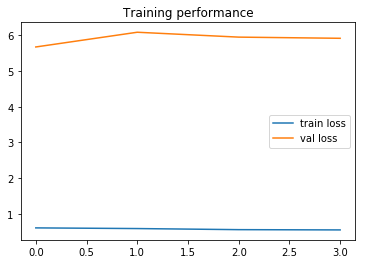

In [15]:
axial_meniscus_model = fit_model(training_set_axial, training_label_meniscus, "axial_meniscus_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.5097 - acc: 0.7866 - val_loss: 2.0211 - val_acc: 0.8421
Epoch 2/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4699 - acc: 0.8062 - val_loss: 2.2087 - val_acc: 0.8421
Epoch 3/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4690 - acc: 0.8062 - val_loss: 1.0163 - val_acc: 0.8421
Epoch 4/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4450 - acc: 0.8080 - val_loss: 1.8489 - val_acc: 0.8421
Epoch 5/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4281 - acc: 0.8127 - val_loss: 1.7880 - val_acc: 0.8421
Epoch 6/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4143 - acc: 0.8164 - val_loss: 4.3359 - val_acc: 0.2632


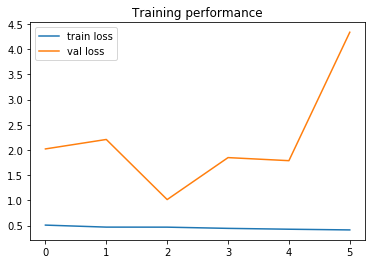

In [16]:
coronal_abnormal_model = fit_model(training_set_coronal, training_label_abnormal, "coronal_abnormal_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.5276 - acc: 0.7959 - val_loss: 2.2160 - val_acc: 0.8421
Epoch 2/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4870 - acc: 0.8155 - val_loss: 2.5419 - val_acc: 0.8421
Epoch 3/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.5008 - acc: 0.8145 - val_loss: 2.0162 - val_acc: 0.8421
Epoch 4/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4810 - acc: 0.8136 - val_loss: 1.1794 - val_acc: 0.8421
Epoch 5/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4620 - acc: 0.8145 - val_loss: 1.5573 - val_acc: 0.8421
Epoch 6/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4668 - acc: 0.8173 - val_loss: 1.9768 - val_acc: 0.8421
Epoch 7/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4600 - acc: 0.8145 - val_loss: 2.1510 - val_acc: 0.8421


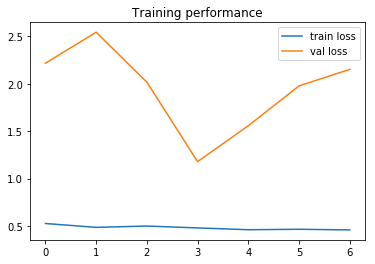

In [17]:
coronal_acl_model = fit_model(training_set_coronal, training_label_acl, "coronal_acl_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.6662 - acc: 0.6337 - val_loss: 1.1381 - val_acc: 0.6316
Epoch 2/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.6114 - acc: 0.6589 - val_loss: 4.0655 - val_acc: 0.6140
Epoch 3/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.6081 - acc: 0.6738 - val_loss: 1.1417 - val_acc: 0.5439
Epoch 4/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.6085 - acc: 0.6552 - val_loss: 2.4011 - val_acc: 0.4737


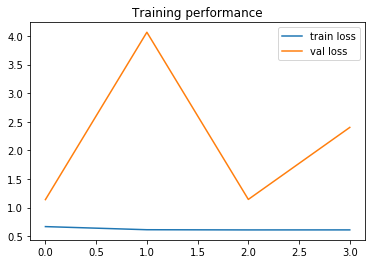

In [18]:
coronal_meniscus_model = fit_model(training_set_coronal, training_label_meniscus, "coronal_meniscus_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.5405 - acc: 0.7866 - val_loss: 1.4923 - val_acc: 0.8421
Epoch 2/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4982 - acc: 0.8062 - val_loss: 1.8887 - val_acc: 0.8421
Epoch 3/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4929 - acc: 0.8062 - val_loss: 1.8712 - val_acc: 0.8421
Epoch 4/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4684 - acc: 0.8062 - val_loss: 1.6549 - val_acc: 0.8421


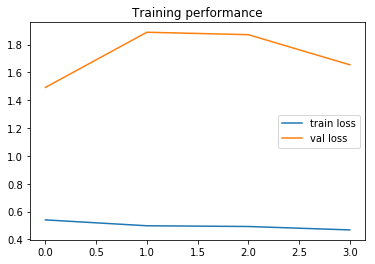

In [19]:
sagittal_abnormal_model = fit_model(training_set_sagittal, training_label_abnormal, "sagittal_abormal_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.7160 - acc: 0.6897 - val_loss: 0.6092 - val_acc: 0.8070
Epoch 2/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.5415 - acc: 0.8145 - val_loss: 0.4788 - val_acc: 0.8421
Epoch 3/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4806 - acc: 0.8145 - val_loss: 0.4593 - val_acc: 0.8421
Epoch 4/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4807 - acc: 0.8145 - val_loss: 0.4518 - val_acc: 0.8421
Epoch 5/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4805 - acc: 0.8145 - val_loss: 0.4590 - val_acc: 0.8421
Epoch 6/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4802 - acc: 0.8145 - val_loss: 0.4809 - val_acc: 0.8421
Epoch 7/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.4802 - acc: 0.8145 - val_loss: 0.4840 - val_acc: 0.8421


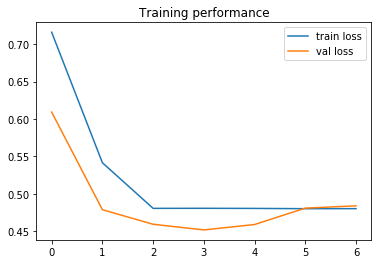

In [20]:
sagittal_acl_model = fit_model(training_set_sagittal, training_label_acl, "sagittal_acl_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.6836 - acc: 0.6505 - val_loss: 0.6807 - val_acc: 0.6140
Epoch 2/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.6480 - acc: 0.6505 - val_loss: 0.6805 - val_acc: 0.5614
Epoch 3/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.6478 - acc: 0.6505 - val_loss: 0.6817 - val_acc: 0.5439
Epoch 4/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.6473 - acc: 0.6505 - val_loss: 0.6825 - val_acc: 0.5439
Epoch 5/30
1073/1073 [==============================] - 4s 4ms/step - loss: 0.6518 - acc: 0.6505 - val_loss: 0.7376 - val_acc: 0.4035


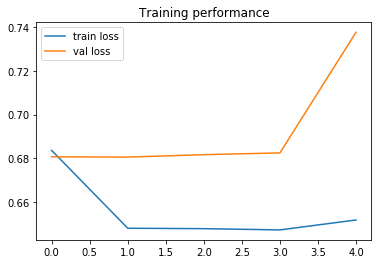

In [21]:
sagittal_meniscus_model = fit_model(training_set_sagittal, training_label_meniscus, "sagittal_meniscus_model")

## Evaluate the 9 models

In [0]:
def testSet(file_name):
  test_set = []
  for np_name in sorted(glob.glob('MRNet-v1.0/valid/'+file_name+'/*.npy')):
        test_set.append(np.load(np_name))
  return test_set   

In [0]:
test_set_axial= testSet('axial')
test_set_coronal=testSet('coronal')
test_set_sagittal=testSet('sagittal')

In [0]:
test_set_axial = extract_3(test_set_axial, 120)
test_set_coronal =extract_3(test_set_coronal, 120)
test_set_sagittal =extract_3(test_set_sagittal, 120)

In [0]:
test_label_abnormal = load_labels('MRNet-v1.0/valid-abnormal.csv')
test_label_acl = load_labels('MRNet-v1.0/valid-acl.csv')
test_label_meniscus = load_labels('MRNet-v1.0/valid-meniscus.csv')

In [26]:
axial_abnormal_model.evaluate(test_set_axial, test_label_abnormal)

120/120 [==============================] - 16s 133ms/step


[1.4890491942564645, 0.774999996026357]

In [27]:
axial_acl_model.evaluate(test_set_axial, test_label_acl) 

120/120 [==============================] - 15s 126ms/step


[4.576516991419097, 0.55]

In [28]:
axial_meniscus_model.evaluate(test_set_axial, test_label_meniscus) 

120/120 [==============================] - 16s 131ms/step


[6.218299196430598, 0.5666666666666667]

In [29]:
coronal_abnormal_model.evaluate(test_set_coronal, test_label_abnormal)

120/120 [==============================] - 16s 130ms/step


[0.8518319875001907, 0.7583333293596903]

In [30]:
coronal_acl_model.evaluate(test_set_coronal, test_label_acl)

120/120 [==============================] - 17s 138ms/step


[3.8368438134901224, 0.55]

In [31]:
coronal_meniscus_model.evaluate(test_set_coronal, test_label_meniscus)

120/120 [==============================] - 16s 129ms/step


[1.459886658191681, 0.5583333333333333]

In [32]:
sagittal_abnormal_model.evaluate(test_set_sagittal, test_label_abnormal)

120/120 [==============================] - 15s 128ms/step


[1.8095693234616193, 0.7916666666666666]

In [41]:
sagittal_acl_model.evaluate(test_set_sagittal, test_label_acl)

120/120 [==============================] - 1s 5ms/step


[0.976259692509969, 0.55]

In [42]:
sagittal_meniscus_model.evaluate(test_set_sagittal, test_label_meniscus)

120/120 [==============================] - 1s 4ms/step


[0.7028600335121155, 0.5666666666666667]

In [0]:
def predict_abnormal(model_input, ground_truth):
  axial_abnormal_prediction= axial_abnormal_model.predict(model_input)
  coronal_abnormal_prediction=coronal_abnormal_model.predict(model_input)
  sagittal_abnormal_prediction=sagittal_abnormal_model.predict(model_input)
  predict_voting = []
  for i in range (len(axial_abnormal_prediction)):
    voting_list =[0, 0] 
    if(axial_abnormal_prediction[i]>0.5):
      voting_list[1] +=1
    else:
        voting_list[0] += 1
    
    if(coronal_abnormal_prediction[i]>0.5):
      voting_list[1] +=1
    else:
        voting_list[0] += 1
     
    if(sagittal_abnormal_prediction[i]>0.5):
      voting_list[1] +=1
    else:
        voting_list[0] += 1
        
    predict_voting.append(np.argmax(voting_list))
    
  
  return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
def predict_acl(model_input, ground_truth):
  axial_acl_prediction= axial_acl_model.predict(model_input)
  coronal_acl_prediction=coronal_acl_model.predict(model_input)
  sagittal_acl_prediction=sagittal_acl_model.predict(model_input)
  predict_voting = []
  for i in range (len(axial_acl_prediction)):
    voting_list =[0, 0] 
    if(axial_acl_prediction[i]>0.5):
      voting_list[1] +=1
    else:
        voting_list[0] += 1
    
    if(coronal_acl_prediction[i]>0.5):
      voting_list[1] +=1
    else:
        voting_list[0] += 1
     
    if(sagittal_acl_prediction[i]>0.5):
      voting_list[1] +=1
    else:
        voting_list[0] += 1
        
    predict_voting.append(np.argmax(voting_list))
    
  
  return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
def predict_meniscus(model_input, ground_truth):
  axial_meniscus_prediction= axial_meniscus_model.predict(model_input)
  coronal_meniscus_prediction=coronal_meniscus_model.predict(model_input)
  sagittal_meniscus_prediction=sagittal_meniscus_model.predict(model_input)
  predict_voting = []
  for i in range (len(axial_meniscus_prediction)):
    voting_list =[0, 0] 
    if(axial_meniscus_prediction[i]>0.5):
      voting_list[1] +=1
    else:
        voting_list[0] += 1
    
    if(coronal_meniscus_prediction[i]>0.5):
      voting_list[1] +=1
    else:
        voting_list[0] += 1
     
    if(sagittal_meniscus_prediction[i]>0.5):
      voting_list[1] +=1
    else:
        voting_list[0] += 1
        
    predict_voting.append(np.argmax(voting_list))
    
  
  return accuracy_score(ground_truth, np.array(predict_voting)) * 100


In [46]:
print (predict_abnormal(test_set_axial, test_label_abnormal))
print (predict_abnormal(test_set_coronal, test_label_abnormal))
print (predict_abnormal(test_set_sagittal, test_label_abnormal))

78.33333333333333
76.66666666666667
75.83333333333333


In [47]:
print (predict_acl(test_set_axial, test_label_acl))
print (predict_acl(test_set_coronal, test_label_acl))
print (predict_acl(test_set_sagittal, test_label_acl))

55.00000000000001
55.00000000000001
55.00000000000001


In [48]:
print (predict_meniscus(test_set_axial, test_label_meniscus))
print (predict_meniscus(test_set_coronal, test_label_meniscus))
print (predict_meniscus(test_set_sagittal, test_label_meniscus))

56.666666666666664
56.666666666666664
55.833333333333336
